# Titanic experiments
In this notebook, we apply the 4 different types of hierarchical shrinkage using a single decision tree on the titanic dataset, with the (uninformative) feature `PassengerID` included. For each type of shrinkage, we inspect average test set accuracy using 10-fold CV and the feature importances for varying values of lambda.

The main expectation is that the MDI feature importance for `PassengerID` will be much lower for models with shrinkage than without.

In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from aughs import ShrinkageClassifier
from sklearn.model_selection import cross_val_score
#from misc import preprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

def preprocess(df):
    # Extract relevant columns
    categorical_columns = ["Sex", "Embarked"]
    numerical_columns = ["Age", "PassengerId", "Pclass"]
    feat_columns = categorical_columns + numerical_columns
    target_column = ["Survived"]

    # Ordinal encode categorical columns
    df[categorical_columns] = OrdinalEncoder().fit_transform(df[categorical_columns])

    # Impute/drop missing values
    df.loc[:, "Age"].fillna(df["Age"].mean(), inplace=True)
    df = df.loc[:, feat_columns + target_column]
    df = df.dropna()
    
    X_df = df.loc[:, feat_columns]
    y_df = df.loc[:, "Survived"]

    return X_df, y_df

In [15]:
#tmp = pd.read_csv("../raw_data/titanic/titanic_train.csv")
#tmp
X_df, y_df = preprocess(pd.read_csv("../raw_data/titanic/titanic_train.csv"))

X_df

,Sex,Embarked,Age,PassengerId,Pclass
0,1.0,2.0,22.000000,1,3
1,0.0,0.0,38.000000,2,1
2,0.0,2.0,26.000000,3,3
3,0.0,2.0,35.000000,4,1
4,1.0,2.0,35.000000,5,3
...,...,...,...,...,...
886,1.0,2.0,27.000000,887,2
887,0.0,2.0,19.000000,888,1
888,0.0,2.0,29.699118,889,3
889,1.0,0.0,26.000000,890,1


In [25]:
Node_Attributes= [1,2,3,4,5]
df = pd.DataFrame([Node_Attributes])
df
df.to_csv(r'Node_Attributes.csv', header=None, index=None, sep=' ', mode='a')

In [30]:
clf = ShrinkageClassifier(shrink_mode="hs_entropy", lmb=10)
clf.fit(X_df, y_df)
print(clf.estimator_.feature_importances_)



[0.53414449 0.040107   0.13123028 0.10861911 0.18589911]


In [32]:

lmbs = np.arange(0, 100, 2)
scores = {}
importances = {}
for shrink_mode in ["hs", "hs_entropy", "hs_entropy_2", "hs_log_cardinality"]:
    scores[shrink_mode] = []
    importances[shrink_mode] = []
    for lmb in lmbs:
        clf = ShrinkageClassifier(shrink_mode=shrink_mode, lmb=lmb)
        scores[shrink_mode].append(
            cross_val_score(clf, X_df.values, y_df.values, cv=10, n_jobs=-1,
                            scoring="balanced_accuracy").mean())
        clf.fit(X_df, y_df)
        importances[shrink_mode].append(clf.estimator_.feature_importances_)
    importances[shrink_mode] = np.vstack(importances[shrink_mode])

KeyboardInterrupt: 

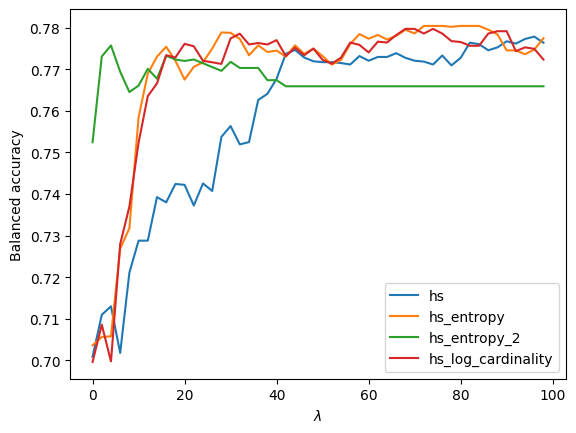

In [19]:
for key in scores:
    plt.plot(lmbs, scores[key], label=key)
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("Balanced accuracy")
plt.show()

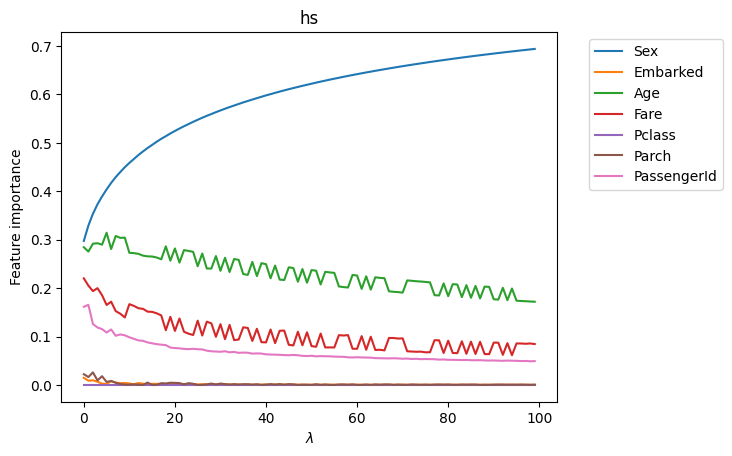

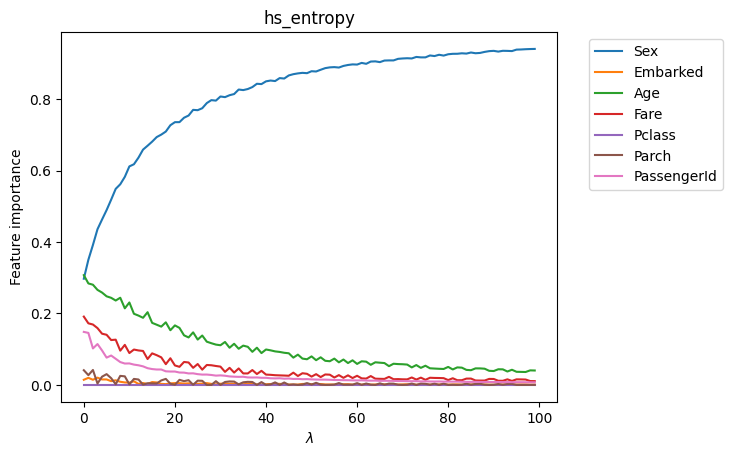

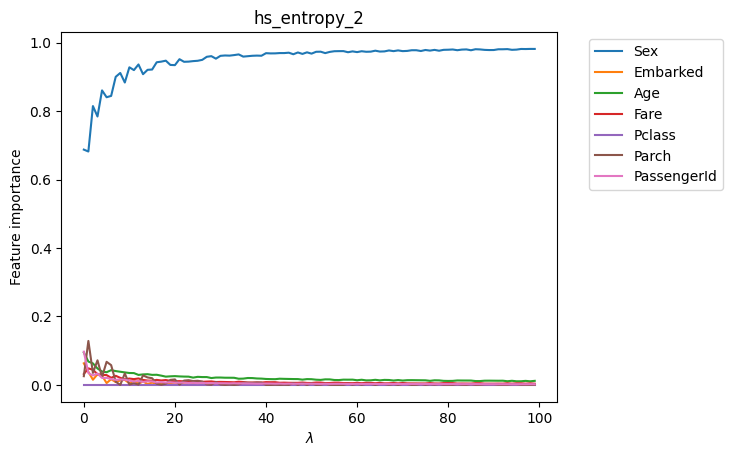

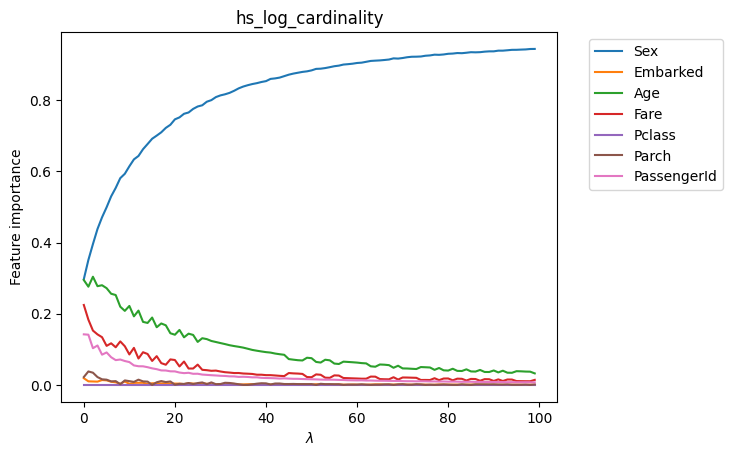

In [4]:
for key in importances:
    line_objects = plt.plot(lmbs, importances[key])
    plt.legend(line_objects, X_df.columns, bbox_to_anchor=(1.05, 1))
    plt.title(key)
    plt.xlabel("$\lambda$")
    plt.ylabel("Feature importance")
    plt.show()